In [1]:
# Python libraries needed to run the TDA based method package ##
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from shapely.wkt import loads
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from mpl_toolkits.mplot3d import Axes3D
from shapely.geometry import MultiPoint
import random
import math
import shapely.affinity
from scipy.spatial import distance
from scipy.spatial import ConvexHull
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import utm
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from shapely.geometry import Point, MultiPolygon
import time
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pyproj import CRS
from pyproj import Proj,transform
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import numpy as np
import rasterio
from rasterio.features import geometry_mask
from osgeo import gdal
import time
import pandas as pd
from scipy.interpolate import griddata
import random 
from gtda.plotting import plot_diagram
from gtda.homology import VietorisRipsPersistence,SparseRipsPersistence,EuclideanCechPersistence
from gtda.diagrams import Amplitude,NumberOfPoints,PersistenceEntropy
from gtda.diagrams import Filtering
import warnings
warnings.filterwarnings("ignore")
from shapely.geometry import Polygon
from shapely.affinity import rotate
# import pywt

def read_shapefiles (path_filename):
    
    """
    function to read the shapefile from the local file path of landslide inventory
    
  
    Parameters:
         :path_filename (str): path to local inventory shapefiles
    
    
    Returns:
         read shapefile from file path
    
    """
    
    return gpd.read_file(path_filename)


def min_max_inventory(poly_data,lon_res,lat_res):

    """
    function to calculate the bounding box coordinates of complete landslide inventory


    Parameters:
          :poly_data (str): landslide polygon data in an inventory
          :lon_res (float): longitude resolution
          :lat_res (float): latitude resolution

    
    Returns:
         bounding box coordinates of landslide inventory region
    
    """
    data_coord=[]
    for l in range((np.shape(poly_data)[0])):
        if poly_data['geometry'][l].geom_type=='Polygon':
            poly_xy=np.asarray(poly_data['geometry'][l].exterior.coords)  ## (lon,lat)
            min_landslide_lon,max_landslide_lon=np.min(poly_xy[:,0]),np.max(poly_xy[:,0])
            min_landslide_lat,max_landslide_lat=np.min(poly_xy[:,1]),np.max(poly_xy[:,1])
            data_coord.append([min_landslide_lon,max_landslide_lon,min_landslide_lat,max_landslide_lat])
    data_coord=np.asarray(data_coord) 
    kk=20
    
    return (np.min(data_coord[:,0])-kk*lon_res, np.max(data_coord[:,1])+kk*lon_res,np.min(data_coord[:,2])+kk*lat_res,np.max(data_coord[:,3])-kk*lat_res)


def latlon_to_eastnorth (lonlat_polydata):
    
    """ 
    function to convert the (longitude latitude) coordinates of polygons to (easting, northing) coordinates
    
    
    Parameters:
          :lonllat_polydata (array_like): 
                             longitude and latitude coordinates data
                      
    Returns:
            (array_like)
            easting and northing coordinates of landslide polygon data when polygon data has longitude latitude coordinates 

    
     
    """
     
    east_north_polydata=[]
    for i in range(np.shape(lonlat_polydata)[0]):
        u = utm.from_latlon(lonlat_polydata[i][1], lonlat_polydata[i][0])   ### (lat,lon) to (east,north)
        east_north_polydata.append([u[0],u[1]])
    east_north_polydata=np.asarray(east_north_polydata) 
    return  east_north_polydata 


def travel_angle_delta_z(geopandas_dataframe, dem_path):
    # Load the DEM and get the geotransform and array
    dem = gdal.Open(dem_path)
    dem_array = dem.ReadAsArray()
    gt = dem.GetGeoTransform()


    # Function to get elevation from DEM
    def get_elevation(x, y, gt, dem_array):
        col = int((x - gt[0]) / gt[1])
        row = int((y - gt[3]) / gt[5])
        return dem_array[row, col]
    

    # Initialize lists to store angles and delta_z values
    angles = []
    delta_zs = []
    travel_distances = []

    # Wrap the loop iterator with tqdm for progress tracking
    for _, landslide in tqdm(geopandas_dataframe.iterrows(), total=geopandas_dataframe.shape[0]):
        # Get the highest and lowest points along the landslide polygon
        min_elev_point = min(landslide.geometry.exterior.coords, key=lambda point: get_elevation(point[0], point[1], gt, dem_array))
        max_elev_point = max(landslide.geometry.exterior.coords, key=lambda point: get_elevation(point[0], point[1], gt, dem_array))

        # Elevation difference
        delta_z = get_elevation(max_elev_point[0], max_elev_point[1], gt, dem_array) - get_elevation(min_elev_point[0], min_elev_point[1], gt, dem_array)

        # Append delta_z to list
        delta_zs.append(delta_z)

        # Horizontal distance
        delta_x = np.sqrt((max_elev_point[0] - min_elev_point[0])**2 + (max_elev_point[1] - min_elev_point[1])**2)

        # Travel angle (in degrees)
        angle = np.arctan2(delta_z, delta_x) * (180 / np.pi)
        
        angles.append(angle)
        travel_distances.append(delta_x)

    geopandas_dataframe['travel_angle'] = angles
    geopandas_dataframe['travel_distance'] = travel_distances
    geopandas_dataframe['delta_z'] = delta_zs

    return geopandas_dataframe

def make_2d_polygons(poly_data):
    data=[]
    geometry_list = [] # To store geometry information
    unique_id_list = [] # To store the  unique IDs

    for l in range((np.shape(poly_data)[0])):   
        geometry = poly_data['geometry'][l] # Retrieve geometry
        unique_id = poly_data['unique_id'][l] # Retrieve unique IDs

        if geometry.geom_type=='Polygon':
            poly_xy=np.asarray(geometry.exterior.coords)  # (lon,lat)
            if np.nanmin(poly_xy) < 100:
                poly_xy=latlon_to_eastnorth(poly_xy)  # Assuming you have defined this function
                area_polygon=Polygon(poly_xy).area
            area_polygon=Polygon(poly_xy).area
            if area_polygon > 0:
                data.append(poly_xy)
                geometry_list.append(geometry)  # Append geometry to list
                unique_id_list.append(unique_id)
    return data, geometry_list, unique_id_list

def make_3d_polygons(poly_data,dem_location,inventory_name,kk):

    """    
    function to get 3D point cloud from 2D shape of landslide

    Parameters:
       :poly_data (str): polygons shapefile
       :dem_location (str): path of dem file
       :inventory_name (str): path of dem file
       :kk (int): kk=1 if user have already DEM corresponding to inventory region otherwise use any other number
   
    Returns:
       (array_like) 3D data of landslides
       
    """
    
    if kk==1:  
       DEM_FILE_NAME=dem_location+inventory_name
    else:
         DEM_FILE_NAME=download_dem(poly_data,dem_location,inventory_name)
    ############################################################################
    inProj = Proj(init='epsg:4326')
    outProj = Proj(init='epsg:3857')
    data=[]
    eleva_polyon=[]
    geometry_list=[] # To store geometry information
    unique_id_list=[] # To store the  unique IDs

    DEM = gdal.Open(DEM_FILE_NAME)
    lon_init,lon_res,_,lat_init,_,lat_res = DEM.GetGeoTransform()
    DEM_data=gdal.Dataset.ReadAsArray(DEM)
    #print(np.shape(DEM_data))

    lon_all=np.arange(lon_init,lon_init+np.shape(DEM_data)[1]*lon_res,lon_res)
    lat_all=np.arange(lat_init,lat_init+np.shape(DEM_data)[0]*lat_res,lat_res)
    
    #print (' ***  Upload Complete Shapefiles Of Landslides In Landslide Inventory ***')
    #print('*** Input should be a shapefiles of landslide polygons  *** ' )
    
    inv_lon_min,inv_lon_max,inv_lat_min,inv_lat_max=min_max_inventory(poly_data,lon_res,lat_res)
    indices_lon_dem_crop_inventory=np.argwhere((lon_all>inv_lon_min)&(lon_all<inv_lon_max))[:,0]
    indices_lat_dem_crop_inventory=np.argwhere((lat_all>inv_lat_min)&(lat_all<inv_lat_max))[:,0]

    min_indices_lon_dem_crop_inventory=np.min(indices_lon_dem_crop_inventory)
    max_indices_lon_dem_crop_inventory=np.max(indices_lon_dem_crop_inventory)

    min_indices_lat_dem_crop_inventory=np.min(indices_lat_dem_crop_inventory)
    max_indices_lat_dem_crop_inventory=np.max(indices_lat_dem_crop_inventory)
    
    DEM_data=DEM_data[min_indices_lat_dem_crop_inventory:max_indices_lat_dem_crop_inventory,
                          min_indices_lon_dem_crop_inventory:max_indices_lon_dem_crop_inventory]
    
    lon_all=lon_all[min_indices_lon_dem_crop_inventory:max_indices_lon_dem_crop_inventory]
    lat_all=lat_all[min_indices_lat_dem_crop_inventory:max_indices_lat_dem_crop_inventory]          ### check 
    
    for l in range((np.shape(poly_data)[0])):
        geometry = poly_data['geometry'][l] # Retrieve geometry
        unique_id = poly_data['unique_id'][l] # Retrieve unique IDs
        print(l)
    #for l in range(100):    
        if poly_data['geometry'][l].geom_type=='Polygon':
            #print(l)
            poly_xy=np.asarray(poly_data['geometry'][l].exterior.coords)  ## (lon,lat)
            ze_1=poly_xy
            
            if np.nanmin(ze_1) < 100:
                ze_1=latlon_to_eastnorth(ze_1)
                area_polygon=Polygon(ze_1).area
                
            if area_polygon>0:    
                #print(area_polygon) 
          
                min_landslide_lon,max_landslide_lon=np.min(poly_xy[:,0]),np.max(poly_xy[:,0])
                min_landslide_lat,max_landslide_lat=np.min(poly_xy[:,1]),np.max(poly_xy[:,1])

                extra=10
                indices_lon_land=np.argwhere((lon_all>min_landslide_lon-extra*lon_res) & (lon_all<max_landslide_lon+extra*lon_res))[:,0]
                indices_lat_land=np.argwhere((lat_all>min_landslide_lat+extra*lat_res) & (lat_all<max_landslide_lat-extra*lat_res))[:,0]

                DEM_landslide_region_crop=DEM_data[np.min(indices_lat_land):np.max(indices_lat_land)+1,
                                                  np.min(indices_lon_land):np.max(indices_lon_land)+1] ############## check 

                lon_landslides_region=lon_all[indices_lon_land]
                lat_landslides_region=lat_all[indices_lat_land]

                ######## for landslide region interpolation #######
                lon_mesh,lat_mesh=np.meshgrid(lon_landslides_region,lat_landslides_region)
                lon_mesh,lat_mesh=lon_mesh.flatten(),lat_mesh.flatten()
                DEM_landslide_region_crop_=DEM_landslide_region_crop.flatten()

                from pyproj import Transformer

                # Create a transformer object for the specific transformation
                transformer = Transformer.from_crs("epsg:4326", "epsg:3857", always_xy=True)


                lon_mesh_east,lat_mesh_north = transformer.transform(lon_mesh, lat_mesh)#transform(inProj,outProj,lon_mesh,lat_mesh)

                poly_xy[:,0],poly_xy[:,1] = transformer.transform(poly_xy[:,0], poly_xy[:,1])#transform(inProj,outProj,poly_xy[:,0],poly_xy[:,1])


                lon_mesh_east=np.reshape(lon_mesh_east,(np.shape(lon_mesh_east)[0],1))
                lat_mesh_north=np.reshape(lat_mesh_north,(np.shape(lat_mesh_north)[0],1))
                lonlat_mesh_eastnorth=np.hstack((lon_mesh_east,lat_mesh_north))

                xmin1,xmax1=np.min(poly_xy[:,0])-30,np.max(poly_xy[:,0])+30
                ymin1,ymax1=np.min(poly_xy[:,1])-30,np.max(poly_xy[:,1])+30
                k,total_grid=0,32
                xnew =np.linspace(xmin1-k, xmax1+k,total_grid)
                ynew =np.linspace(ymin1-k, ymax1+k,total_grid) 

                xneww,yneww=np.meshgrid(xnew,ynew)


                eleva_inter=griddata(lonlat_mesh_eastnorth, DEM_landslide_region_crop_,(xneww,yneww),method='cubic')
                eleva_poly=griddata(lonlat_mesh_eastnorth, DEM_landslide_region_crop_,(poly_xy[:,0],poly_xy[:,1]),method='cubic')
                poly_norm=(eleva_poly-np.min(eleva_poly))
                
                eleva_final=eleva_inter
                #eleva_norm=(eleva_final-np.min(eleva_final))/(np.max(eleva_final)-np.min(eleva_final))
                eleva_norm=eleva_final
                #######################################################################################################################
                polygon = Polygon(poly_xy)
                XNEW,YNEW=np.meshgrid(xnew,ynew)
                XNEW,YNEW=XNEW.flatten(),YNEW.flatten()
                combine_data=np.zeros((total_grid*total_grid,3))
                combine_data[:,0]=XNEW
                combine_data[:,1]=YNEW

                  #print('elevation')
                ELEVA_NORM=eleva_norm.flatten()
                combine_data[:,2]=ELEVA_NORM

                ##################################################################################################
                indices=[]
                for i in range(np.shape(combine_data)[0]):
                    point=Point(combine_data[i,0:2])
                    if polygon.contains(point)==True:
                       indices.append(i) 

                indices=np.asarray(indices)
                if np.shape(indices)[0]>0:
                    combine_data=combine_data[indices]
                    #combine_data[:,0]=(combine_data[:,0]-np.min(combine_data[:,0]))/(np.max(combine_data[:,0])-np.min(combine_data[:,0]))
                    #combine_data[:,1]=(combine_data[:,1]-np.min(combine_data[:,1]))/(np.max(combine_data[:,1])-np.min(combine_data[:,1]))
                    #combine_data[:,2]=(combine_data[:,2]-np.min(combine_data[:,2]))/(np.max(combine_data[:,2])-np.min(combine_data[:,2]))
                    
                    combine_data[:,0]=(combine_data[:,0]-np.min(combine_data[:,0]))
                    combine_data[:,1]=(combine_data[:,1]-np.min(combine_data[:,1]))
                    combine_data[:,2]=(combine_data[:,2]-np.min(combine_data[:,2]))
                    
                    data.append(combine_data)
                    #eleva_polyon.append([poly_xy[:,0]-np.min(combine_data[:,0]),poly_xy[:,1]-np.min(combine_data[:,1]),poly_norm])
                    a1=(poly_xy[:,0]-np.min(poly_xy[:,0]))/(np.max(poly_xy[:,0])-np.min(poly_xy[:,0]))
                    b1=(poly_xy[:,1]-np.min(poly_xy[:,1]))/(np.max(poly_xy[:,1])-np.min(poly_xy[:,1]))
                    c1=(poly_norm-np.min(poly_norm))/(np.max(poly_norm)-np.min(poly_norm))
                    a1=a1[:,np.newaxis]
                    b1=b1[:,np.newaxis]
                    c1=c1[:,np.newaxis]
                    
                    eleva_polyon.append(np.hstack((a1,b1,c1)))
                    geometry_list.append(geometry)  # Append geometry to list
                    unique_id_list.append(unique_id)
                    
    return eleva_polyon, geometry_list, unique_id_list

def find_rel_source_length(source,combine):
    label=[]
    data=[]
    for l in tqdm(range(len(source))):
        bound_box= combine['geometry'][l].minimum_rotated_rectangle
        coordinates_BB=np.asarray(bound_box.exterior.coords)
        tan_y=(coordinates_BB[1,1]-coordinates_BB[0,1])/(coordinates_BB[1,0]-coordinates_BB[0,0])
        theta=math.degrees(math.atan(tan_y))

        rot_combine=rotate(combine['geometry'][l], -theta-90)
        rot_source=rotate(source['geometry'][l], -theta-90)

        length_comp=(max(np.asarray(rot_combine.exterior.coords)[:,1])-
                 min(np.asarray(rot_combine.exterior.coords)[:,1]))

        length_source=(max(np.asarray(rot_source.exterior.coords)[:,1])-
                 min(np.asarray(rot_source.exterior.coords)[:,1]))

        label.append(length_source/length_comp)
        #print(l,length_source/length_comp)

        #print(length_comp,np.abs(length_comp-(length_source+length_runout)))
    return label

def create_landslide_input_tables(geopandas_dataframe, dem_raster_path):
    # Load landslide polygons and DEM raster
    landslides_gdf = geopandas_dataframe# gpd.read_file(landslide_shp_path).head(1000)  # Using first N for testing
    with rasterio.open(dem_raster_path) as dem_src:
        dem_array = dem_src.read(1)
    
    # Initialize result DataFrames
    table_1 = pd.DataFrame(columns=['unique_id', 'x1', 'y1', 'elev'])
    table_2 = pd.DataFrame(columns=['unique_id', 'x', 'y', 'GRID_CODE', 'L', 'delta_h'])
    
    # Iterate over each landslide polygon
    for idx, landslide in tqdm(landslides_gdf.iterrows(), total=len(landslides_gdf), desc='Processing Landslides'):
        
        # Create a mask for the current landslide polygon
        mask = geometry_mask([landslide['geometry']], transform=dem_src.transform, invert=True, out_shape=dem_array.shape)
        
        # Coordinates and elevations within this polygon
        elevations = dem_array[mask]
        coordinates = np.argwhere(mask)
        
        # Calculate the highest elevation within this polygon (for Table 1)
        highest_elev = elevations.max()
        
        # Filter the indices to only include those that fall within the mask
        highest_idx_filtered = [idx for idx in np.argwhere(dem_array == highest_elev) if mask[tuple(idx)]][0]
        
        y_idx, x_idx = highest_idx_filtered
        x1, y1 = dem_src.xy(y_idx, x_idx)
        
        # Populate Table 1
        table_1 = table_1.append({'unique_id': idx, 'x1': x1, 'y1': y1, 'elev': highest_elev, 'geometry': landslide['geometry']}, ignore_index=True)
        
        # Populate x, y, GRID_CODE (for Table 2)
        for y_idx, x_idx in tqdm(coordinates, desc=f'Processing Coordinates for Landslide {idx}', leave=False):
            x, y = dem_src.xy(y_idx, x_idx)
            grid_code = dem_array[y_idx, x_idx]
            table_2 = table_2.append({'unique_id': idx, 'x': x, 'y': y, 'GRID_CODE': grid_code}, ignore_index=True)
        
        # Calculate L (Length of the landslide, for Table 2)
        min_rect = landslide['geometry'].minimum_rotated_rectangle
        min_rect_coords = np.array(min_rect.exterior.coords)[:4]
        length = np.max([np.linalg.norm(min_rect_coords[i] - min_rect_coords[i-1]) for i in range(1, 4)])
        
        # Populate L (for Table 2)
        table_2.loc[table_2['unique_id'] == idx, 'L'] = length
        
        # Calculate delta_h (elevation difference between TOP and TIP, for Table 2)
        delta_h = highest_elev - elevations.min()
        
        # Populate delta_h (for Table 2)
        table_2.loc[table_2['unique_id'] == idx, 'delta_h'] = delta_h
    
    # Convert DataFrames to GeoDataFrames and set CRS
    crs = landslides_gdf.crs
    table_1_gdf = gpd.GeoDataFrame(table_1, geometry='geometry', crs=crs)
    table_2_gdf = gpd.GeoDataFrame(table_2, geometry=gpd.points_from_xy(table_2.x, table_2.y), crs=crs)
    
    return table_1_gdf, table_2_gdf

def calculate_velocity(table_1_gdf, table_2_gdf):
    """
    Function to calculate various landslide parameters and velocities based on input GeoDataFrames.
    
    Parameters:
    - table_1_gdf: GeoDataFrame containing 'unique_id', 'x1', 'y1', and 'elev'
    - table_2_gdf: GeoDataFrame containing 'unique_id', 'x', 'y', 'GRID_CODE', 'L', and 'delta_h'
    
    Returns:
    - OUT_DATA: GeoDataFrame with calculated parameters
    - table_velmax: DataFrame with maximum velocity for each landslide
    """
    
    # Initialize new columns in table_2_gdf for storing calculated values
    table_2_gdf['L_new'] = np.nan
    table_2_gdf['maxEL'] = np.nan
    table_2_gdf['tanAlfa'] = table_2_gdf['delta_h'] / table_2_gdf['L']  # tanAlfa = delta_h / L
    table_2_gdf['G'] = np.nan
    table_2_gdf['Q2'] = np.nan
    table_2_gdf['K'] = np.nan
    table_2_gdf['Vel'] = np.nan
    
    # Loop through each unique landslide ID to calculate L_new and maxEL
    for l_id in tqdm(table_1_gdf['unique_id'].unique()):
        # Extract rows corresponding to the current unique_id in both tables
        row_table_1 = table_1_gdf[table_1_gdf['unique_id'] == l_id]
        rows_table_2 = table_2_gdf[table_2_gdf['unique_id'] == l_id]
        
        # Calculate L_new: Euclidean distance from each point to the top point (x1, y1) of the landslide
        table_2_gdf.loc[rows_table_2.index, 'L_new'] = np.sqrt((row_table_1['x1'].values[0] - rows_table_2['x'])**2 +
                                                                (row_table_1['y1'].values[0] - rows_table_2['y'])**2)       

        # Store the maximum elevation (elev) for each point in the landslide
        table_2_gdf.loc[rows_table_2.index, 'maxEL'] = row_table_1['elev'].values[0]
        
        # Calculate G, Q2, K and Vel for each point in the landslide
        table_2_gdf.loc[rows_table_2.index, 'G'] = table_2_gdf.loc[rows_table_2.index, 'L_new'] * table_2_gdf.loc[rows_table_2.index, 'tanAlfa']
        table_2_gdf.loc[rows_table_2.index, 'Q2'] = table_2_gdf.loc[rows_table_2.index, 'maxEL'] - table_2_gdf.loc[rows_table_2.index, 'G']
        table_2_gdf.loc[rows_table_2.index, 'K'] = table_2_gdf.loc[rows_table_2.index, 'Q2'] - table_2_gdf.loc[rows_table_2.index, 'GRID_CODE']
        
        # Filter negative K values
        table_2_gdf.loc[(table_2_gdf['unique_id'] == l_id) & (table_2_gdf['K'] < 0), 'K'] = np.nan
        
        # Calculate Vel
        table_2_gdf.loc[rows_table_2.index, 'Vel'] = np.sqrt(table_2_gdf.loc[rows_table_2.index, 'K'] * 2 * 9.81) # g=9.81 i.e. gravity
    
    OUT_DATA = table_2_gdf[['unique_id', 'x', 'y', 'GRID_CODE', 'L', 'delta_h', 'L_new', 'tanAlfa', 'G', 'Q2', 'K', 'Vel']]
    
    # Create the 'landslide maximum velocity' table (table_velmax)
    velMax = OUT_DATA.groupby('unique_id')['Vel'].max().reset_index()
    table_velmax = velMax.rename(columns={'Vel': 'V_Max'})
    
    return OUT_DATA, table_velmax

def get_ml_features(data, geometry_list,unique_id_list):

    homology_dimensions = [0, 1, 2]
    from gtda.homology import VietorisRipsPersistence,SparseRipsPersistence,EuclideanCechPersistence
    persistence = VietorisRipsPersistence(metric="euclidean",homology_dimensions=homology_dimensions,n_jobs=6,collapse_edges=True)
    data= persistence.fit_transform(data)
    data=Filtering(homology_dimensions=[0,1,2],epsilon=0.6).fit_transform(data)
    #data=Filtering(homology_dimensions=[0,1,2],epsilon=0.03).fit_transform(data)

    
    def average_lifetime(pers_diagrams_one):
        homology_dimensions = [0, 1, 2]
        persistence_diagram =pers_diagrams_one
        persistence_table = pd.DataFrame(persistence_diagram, columns=["birth", "death", "homology_dim"])
        persistence_table["lifetime"] = persistence_table["death"] - persistence_table["birth"] 
        life_avg_all_dims=[]

        for dims in homology_dimensions:
            avg_lifetime_one=persistence_table[persistence_table['homology_dim']==dims]['lifetime'].mean()
            life_avg_all_dims.append(avg_lifetime_one)
        life_avg_all_dims=np.asarray(life_avg_all_dims)
        life_avg_all_dims=life_avg_all_dims.flatten() 
        return life_avg_all_dims   

    metrics=["bottleneck", "wasserstein", "landscape",'heat','betti',"persistence_image","silhouette"]
    feature_all_data=[]
    for i in tqdm(range(np.shape(data)[0])):
        if (i%500)==0:
            print(i) 
        feature_total_one=[]
        persistant_one = data[i][None, :, :]
        
        persistence_entropy = PersistenceEntropy()
        feature_onemeasure_entrophy = persistence_entropy.fit_transform(persistant_one)
        feature_total_one.append(feature_onemeasure_entrophy)

        feature_onemeasure=NumberOfPoints().fit_transform(persistant_one)
        feature_total_one.append(feature_onemeasure)

        feature_onemeasure=average_lifetime(data[i])  
        feature_onemeasure=feature_onemeasure.reshape(1,3)
        feature_total_one.append(feature_onemeasure)

        for metric in metrics:
            feature_onemeasure=Amplitude(metric=metric).fit_transform(persistant_one)
            feature_total_one.append(feature_onemeasure)

        feature_total_one=np.asarray(feature_total_one)     
        feature_total_one=feature_total_one.flatten()

        feature_all_data.append(feature_total_one)
    feature_all_data=np.asarray(feature_all_data)  

    result = {
        'features': feature_all_data,
        'geometry': geometry_list,
        'unique_id': unique_id_list
    }

    return result #feature_all_data  

def combined_features(geopandas_dataframe, dem_path, point_cloud_data, point_cloud_unique_id):
    # Load the shapefile into a GeoPandas DataFrame
    gdf = geopandas_dataframe # gpd.read_file(shapefile_path)

    # Validate if the shapefile and point_cloud_unique_id have the same length
    if len(gdf) != len(point_cloud_unique_id):
        raise ValueError("The lengths of the GeoPandas DataFrame and point_cloud_unique_id do not match.")

    # Validate if the unique_ids match in both shapefile and point_cloud_unique_id
    if not all(gdf['unique_id'] == point_cloud_unique_id):
        raise ValueError("The 'unique_id' in GeoPandas DataFrame and point_cloud_unique_id do not match.")
    
    # Run travel_angle_delta_z function
    gdf = travel_angle_delta_z(gdf, dem_path)
    
    # Extract the 'travel_angle', 'travel_distance', and 'delta_z' as numpy arrays
    travel_angle_array = np.array(gdf['travel_angle']).reshape(-1, 1)
    travel_distance_array = np.array(gdf['travel_distance']).reshape(-1, 1)
    delta_z_array = np.array(gdf['delta_z']).reshape(-1, 1)

    # Extract velocities and calculate fourier and wavelet transforms
    table_1_gdf, table_2_gdf = create_landslide_input_tables(gdf, dem_path)
    OUT_DATA, table_velmax = calculate_velocity(table_1_gdf, table_2_gdf)

    # Initialize an empty list to hold the velocity features
    avg_K_features = []
    avg_velocity_features = []
    max_velocity_features = []

    # Loop through each unique ID to perform Fourier and Wavelet transforms
    for uid in tqdm(OUT_DATA['unique_id'].unique(), desc="Processing unique IDs"):
        landslide_data = OUT_DATA[OUT_DATA['unique_id'] == uid]
        velocity_series = landslide_data['Vel'].dropna()  # Remove NaNs # velocity
        
        # # Average and Maximum Velocity
        avg_velocity = np.mean(velocity_series)
        # max_velocity = np.max(velocity_series)
        
        # fourier_features.append(fourier_feature)
        avg_velocity_features.append(avg_velocity)
        # max_velocity_features.append(max_velocity)

    avg_velocity_df = pd.DataFrame(avg_velocity_features, columns=['Avg_Velocity'])
    # max_velocity_df = pd.DataFrame(max_velocity_features, columns=['Max_Velocity'])

    # Run get_ml_features function for TDA features
    ml_features_result = get_ml_features(point_cloud_data, gdf['geometry'].tolist(), point_cloud_unique_id)
    ml_features_array = ml_features_result['features']

    # Concatenate the travel_angle, delta_z, and transforms to the machine learning features
    combined_features_array = np.hstack((
                                         ml_features_array, # For TDA features 
                                         travel_angle_array, travel_distance_array, delta_z_array, # For topographical features
                                         avg_velocity_df.values # For Kinetic Velocity features
                                         ))

    # Combine everything into one result dictionary
    combined_result = {
        'features': combined_features_array,
        'geometry': ml_features_result['geometry'],
        'unique_id': ml_features_result['unique_id']
    }

    return combined_result

def remove_multipolygons(df, geometry_col='geometry'):
    # Count and check for MultiPolygon geometries initially
    initial_multipolygon_count = df[geometry_col].apply(lambda x: isinstance(x, MultiPolygon)).sum()
    
    if initial_multipolygon_count > 0:
        print(f"Initial GeoDataFrame contains {initial_multipolygon_count} MultiPolygon geometries.")
        
        # Remove MultiPolygon geometries
        df_filtered = df[~df[geometry_col].apply(lambda x: isinstance(x, MultiPolygon))]
        
        # Recheck for MultiPolygon geometries
        final_multipolygon_count = df_filtered[geometry_col].apply(lambda x: isinstance(x, MultiPolygon)).sum()
        
        if final_multipolygon_count == 0:
            print("MultiPolygon geometries successfully removed.")
        else:
            print(f"Failed to remove all MultiPolygon geometries. {final_multipolygon_count} remaining.")
        
        return df_filtered
    else:
        print("Initial GeoDataFrame does not contain any MultiPolygon geometries. Total landslides without MultiPolygons are: ", len(df_filtered))
        return df
    
def find_rel_source_length_matched(source, combine):
    label = []

    # Ensure we're working with the same set of unique IDs
    matched_ids = set(source['unique_id']).intersection(set(combine['unique_id']))
    
    # Iterate over the matched unique IDs
    for unique_id in matched_ids:
        # Find the corresponding rows in both dataframes
        source_row = source[source['unique_id'] == unique_id].iloc[0]
        combine_row = combine[combine['unique_id'] == unique_id].iloc[0]

        # Get the minimum rotated rectangle and its coordinates
        bound_box = combine_row.geometry.minimum_rotated_rectangle
        coordinates_BB = np.array(bound_box.exterior.coords)

        # Calculate the angle of rotation needed
        delta_x = coordinates_BB[1, 0] - coordinates_BB[0, 0]
        delta_y = coordinates_BB[1, 1] - coordinates_BB[0, 1]
        # Avoid division by zero
        if delta_x == 0:
            theta = 90
        else:
            tan_y = delta_y / delta_x
            theta = math.degrees(math.atan(tan_y))

        # Rotate geometries
        rot_combine = rotate(combine_row.geometry, -theta-90, origin='centroid')
        rot_source = rotate(source_row.geometry, -theta-90, origin='centroid')

        # Calculate lengths
        length_comp = np.ptp(np.array(rot_combine.exterior.coords)[:, 1])
        length_source = np.ptp(np.array(rot_source.exterior.coords)[:, 1])

        # Calculate the relative length and append to the list
        relative_length = length_source / length_comp
        label.append(relative_length)

    return label

In [8]:
# Read data
dem_path = r"path_to_directory\SRTM_Turkey_resampled_10m_UTM.tif"

merge_datafile = read_shapefiles(r"path_to_directory\merge_landslides_UTM.shp")
source_datafile = read_shapefiles(r"path_to_directory\source_landslides_UTM.shp")
runout_datafile = read_shapefiles(r"path_to_directory\runout_landslides_UTM.shp")

In [3]:
# Find the intersection of 'unique_id' from both dataframes
common_ids = merge_datafile['unique_id'].isin(source_datafile['unique_id'])

# Extract rows with matching 'unique_id' from both dataframes
merge_common = merge_datafile[common_ids]
merge_common = merge_common.drop_duplicates(subset='unique_id')
source_common = source_datafile[source_datafile['unique_id'].isin(merge_common['unique_id'])]

source_exploded = source_common.explode(ignore_index=True)
merge_exploded = merge_common.explode(ignore_index=True)

# After exploding, we should ensure that the 'unique_id' column is still present
# If not, we need to recreate it from the index or from another method of tracking the original geometries
if 'unique_id' not in source_exploded.columns or 'unique_id' not in merge_exploded.columns:
    # Assuming the 'unique_id' was at the same index as geometries, we would create it from the index
    # This is a placeholder operation and would need to be adjusted based on actual data structure
    source_exploded['unique_id'] = source_exploded.index
    merge_exploded['unique_id'] = merge_exploded.index

source_exploded = source_exploded.drop_duplicates(subset='unique_id')
merge_exploded = merge_exploded.drop_duplicates(subset='unique_id')

# Ascending order based on unique_id
source_exploded = source_exploded.sort_values(by='unique_id').reset_index(drop=True)
merge_exploded = merge_exploded.sort_values(by='unique_id').reset_index(drop=True)

len(source_exploded), len(merge_exploded)

(810, 810)

In [4]:
# We remove landslides scarps under 100m2 for redundancy issues with the DEM
print('Before filtering: ',len(source_exploded), len(merge_exploded))

source_datafile_filtered = source_exploded[source_exploded.geometry.area >= 50]
source_datafile_filtered = source_datafile_filtered.set_index('unique_id') # Set 'unique_id' as the primary index
merge_exploded_UTM = merge_exploded.set_index('unique_id')
merge_datafile_filtered = merge_exploded_UTM.loc[source_datafile_filtered.index] # Filter out only the common 'unique_id' landslides

# Reset the index
source_exploded=source_datafile_filtered.reset_index()
merge_exploded=merge_datafile_filtered.reset_index()

print('After filtering: ',len(source_exploded), len(merge_exploded))

Before filtering:  810 810
After filtering:  783 783


In [9]:
pointcloud_combine, geometry, unique_id=make_2d_polygons(merge_exploded)
merge_exploded_training = merge_exploded.set_crs(epsg='32636', inplace=True, allow_override=True)
features_combine = combined_features(merge_exploded, dem_path, pointcloud_combine, unique_id)
print(np.shape(features_combine['features']))

  1%|          | 8/783 [00:00<00:10, 73.00it/s]

0


 65%|██████▌   | 512/783 [00:06<00:03, 72.69it/s]

500


100%|██████████| 783/783 [00:09<00:00, 79.24it/s]

(783, 34)


In [13]:
data=features_combine['features']
label=find_rel_source_length(source_exploded,merge_exploded)
label=np.asarray(label)

100%|██████████| 783/783 [00:01<00:00, 484.58it/s]


## K-fold for model robustness and feature importance selection

In [14]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import time

# Initialize your data and label here
geometry_list = features_combine['geometry']
unique_id_list = features_combine['unique_id']

feature=[]
TrainGeometry, TestGeometry = [], [] # Lists to store geometry of train and test sets
Train_ID, Test_ID = [], []

for ee in range(10): 
    
    start_time = time.time()
    print(ee)
    Train,Test=[],[]
    Trainlabel,Testlabel=[],[]
    feato=[]
    kf = KFold(n_splits=10,shuffle=True)  
    for train_index, test_index in kf.split(data):
        Train.append(data[train_index,:])
        Test.append(data[test_index,:])
        Trainlabel.append(label[train_index])
        Testlabel.append(label[test_index])
        
        # Record the corresponding geometries
        TrainGeometry.append([geometry_list[i] for i in train_index])
        TestGeometry.append([geometry_list[i] for i in test_index])

        # Record the corresponding ids
        Train_ID.append([unique_id_list[i] for i in train_index])
        Test_ID.append([unique_id_list[i] for i in test_index])

    for k in range(10):
        Classifier = RandomForestRegressor(n_estimators=100) 
        scaler = StandardScaler()
        train_data = scaler.fit_transform(Train[k])
        test_data = scaler.transform(Test[k])
        Classifier.fit(train_data, np.ravel(Trainlabel[k]))      
        y_pred = Classifier.predict(test_data)
        Featur_importance = Classifier.feature_importances_
        feato.append(Featur_importance)

    feature.append(np.average(np.asarray(feato),axis=0)) 
    print("--- %s seconds ---" % (time.time() - start_time))    

FEATURE_IMP = np.asarray(feature)
FEATURE_IMP = np.average(FEATURE_IMP, axis=0)

0
--- 19.439446210861206 seconds ---
1
--- 18.89534878730774 seconds ---
2
--- 18.518027782440186 seconds ---
3
--- 18.206974983215332 seconds ---
4
--- 18.43504548072815 seconds ---
5
--- 18.963210821151733 seconds ---
6
--- 19.503506422042847 seconds ---
7
--- 19.56837010383606 seconds ---
8
--- 19.683071851730347 seconds ---
9
--- 19.004048824310303 seconds ---


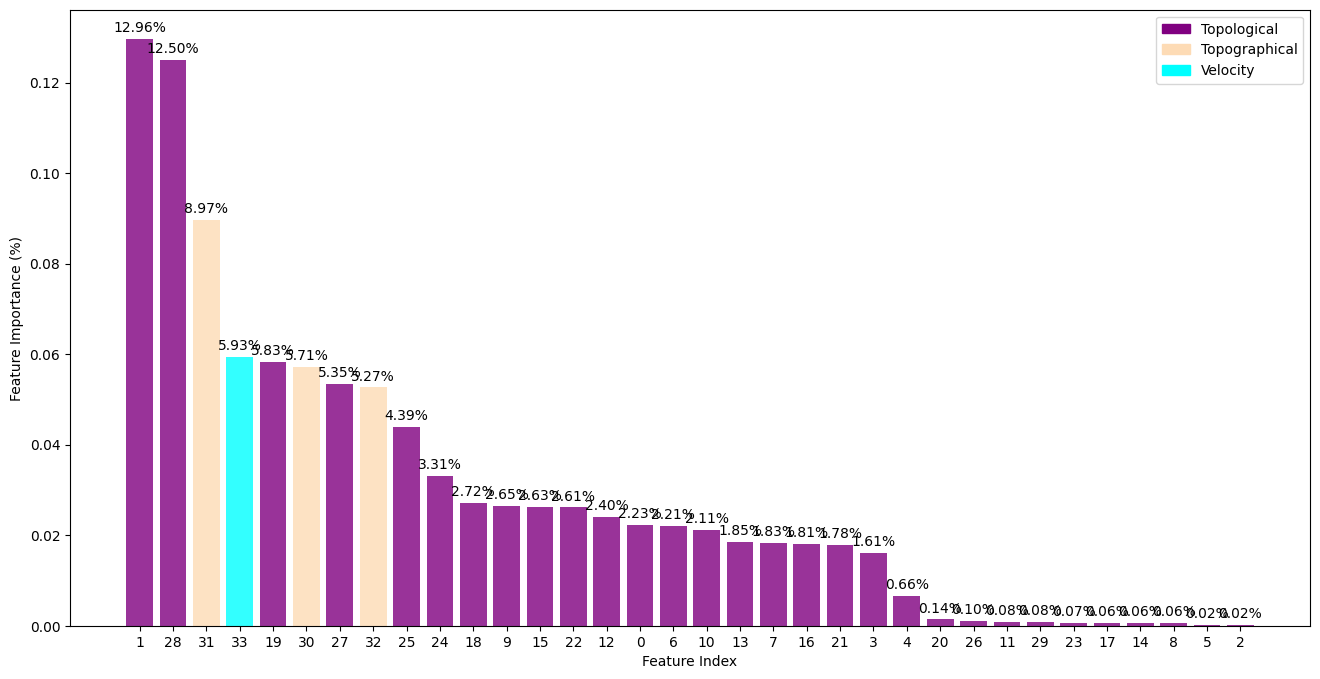

In [15]:
# Plotting feature importance
sorted_idx = FEATURE_IMP.argsort()[::-1]
sorted_importance = FEATURE_IMP[sorted_idx]

fig, ax = plt.subplots(figsize=(16, 8))
colors = ['purple' if i < 30 else ('#fddbb5' if i <= 32 else 'cyan') for i in sorted_idx]

bars = ax.bar(range(len(sorted_importance)), sorted_importance, align='center', alpha=0.8, color=colors, capsize=10)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.annotate(f'{sorted_importance[i]:.2%}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

ax.set_xticks(range(len(sorted_importance)))
ax.set_xticklabels(sorted_idx)
ax.set_xlabel('Feature Index')
ax.set_ylabel('Feature Importance (%)')

topological_patch = mpatches.Patch(color='purple', label='Topological')
topographical_patch = mpatches.Patch(color='#fddbb5', label='Topographical')
velocity_patch = mpatches.Patch(color='cyan', label='Velocity')
plt.legend(handles=[topological_patch, topographical_patch, velocity_patch])
plt.show()

In [16]:
#############################################################################################################
imp_features=np.argsort(-FEATURE_IMP)[0:10] # Selecting the first 10 features/properties
DATA=data[:,imp_features]

## K-Fold with optimized features and ensemble prediction

In [17]:
def calculate_metrics(train_data, test_data, train_label, test_label, geometry, unique_id):
    # Fit and predict
    scaler = StandardScaler()
    train_data_scaled = scaler.fit_transform(train_data)
    test_data_scaled = scaler.transform(test_data)
    classifier = RandomForestRegressor(n_estimators=100, max_depth=None)
    classifier.fit(train_data_scaled, np.ravel(train_label))
    y_pred = classifier.predict(test_data_scaled)
    
    # Calculate the metric
    df = pd.DataFrame({
        'truth_ratio': test_label,
        'pred_ratio': y_pred,
        'geometry': geometry,
        'unique_id': unique_id
    })
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    gdf['total_length'] = gdf['geometry'].apply(lambda x: x.minimum_rotated_rectangle.exterior.coords).apply(calculate_length)
    gdf['pred_source_length'] = gdf['total_length'] * gdf['pred_ratio']
    gdf['truth_source_length'] = gdf['total_length'] * gdf['truth_ratio']
    merged_gdf = gdf.merge(source_datafile[['unique_id', 'geometry']], on='unique_id', how='inner', suffixes=('', '_source'))
    merged_gdf['deviation_metric'] = (np.abs(merged_gdf['truth_source_length'] - merged_gdf['pred_source_length']) / merged_gdf['total_length']) * 100
    return merged_gdf['deviation_metric'].mean()

def calculate_length(coords):
    # Function to calculate total length from coordinates
    coordinates = np.asarray(coords)
    tan_y = (coordinates[1,1] - coordinates[0,1]) / (coordinates[1,0] - coordinates[0,0])
    theta = math.degrees(math.atan(tan_y))
    rot = rotate(shapely.geometry.LineString(coordinates), -theta-90)
    return max(np.asarray(rot.coords)[:,1]) - min(np.asarray(rot.coords)[:,1])

# Splitting the data into a fixed training set
train_data, test_data, train_label, test_label, train_geometry, test_geometry, train_id, test_id = train_test_split(
    DATA, label, geometry_list, unique_id_list, test_size=0.3, random_state=42)

# Initialize a DataFrame to store all predictions for the test data
all_predictions = pd.DataFrame(index=range(test_data.shape[0]))

# Main loop
kf = KFold(n_splits=10, shuffle=True, random_state=42)
deviation_metrics = []

for ee in range(10):
    start_time = time.time()
    print('Model run', ee+1)

    for train_index, test_index in kf.split(train_data):
        fold_train_data, fold_train_label = train_data[train_index], train_label[train_index]
        fold_train_geometry, fold_train_id = [train_geometry[i] for i in train_index], [train_id[i] for i in train_index]

        # Calculate metric on the fixed test set
        metric = calculate_metrics(fold_train_data, test_data, fold_train_label, test_label, test_geometry, test_id)
        deviation_metrics.append(metric)

        scaler = StandardScaler()
        fold_train_data_scaled = scaler.fit_transform(fold_train_data)
        test_data_scaled = scaler.transform(test_data)
        classifier = RandomForestRegressor(n_estimators=100, max_depth=None)
        classifier.fit(fold_train_data_scaled, np.ravel(fold_train_label))
        y_pred = classifier.predict(test_data_scaled)

        # Store the predictions
        all_predictions[f'model_{ee}_{train_index[0]}'] = y_pred

    print("--- %s seconds ---" % (time.time() - start_time))

# Calculate average predictions
average_predictions = all_predictions.mean(axis=1)

gdf_test = gpd.GeoDataFrame({
    'unique_id': test_id,
    'geometry': test_geometry,
    'truth_ratio': test_label,
    'pred_ratio': average_predictions
}, geometry='geometry')

gdf_test['total_length'] = gdf_test['geometry'].apply(lambda x: x.minimum_rotated_rectangle.exterior.coords).apply(calculate_length)
gdf_test['pred_source_length'] = gdf_test['total_length'] * gdf_test['pred_ratio']
gdf_test['truth_source_length'] = gdf_test['total_length'] * gdf_test['truth_ratio']

# Calculate deviation_metric for the averaged predictions
gdf_test['deviation_metric'] = (np.abs(gdf_test['truth_source_length'] - gdf_test['pred_source_length']) / gdf_test['total_length']) * 100

# Merge the predictions with the source_datafile data to get the source geometry for plotting and comparison
merged_gdf = gdf_test.merge(source_datafile[['unique_id', 'geometry']], on='unique_id', how='inner', suffixes=('', '_source'))

average_deviation_metric = np.mean(deviation_metrics)
std_deviation_metric = np.std(deviation_metrics)
print("Mean Deviation Metric:", average_deviation_metric)
print("Standard Deviation of the Deviation Metric:", std_deviation_metric)

Model run 1
--- 13.495692253112793 seconds ---
Model run 2
--- 13.707545518875122 seconds ---
Model run 3
--- 14.238268852233887 seconds ---
Model run 4
--- 13.933606386184692 seconds ---
Model run 5
--- 13.346940994262695 seconds ---
Model run 6
--- 13.843939542770386 seconds ---
Model run 7
--- 14.565264463424683 seconds ---
Model run 8
--- 13.981962203979492 seconds ---
Model run 9
--- 13.903085470199585 seconds ---
Model run 10
--- 13.664081811904907 seconds ---
Mean Deviation Metric: 12.537301967195074
Standard Deviation of the Deviation Metric: 0.1468291750935744


## Plotting results and accuracy graphs

Example number =  196
Scaling factor =  0.26101451020284683
Adjusted scaling factor = 0.9135507857099638
Length of the actual scarp = 32.26983356010169
Length of the predicted scarp = 29.148576946007722
Length of the entire landslide body = 56.874133886769414


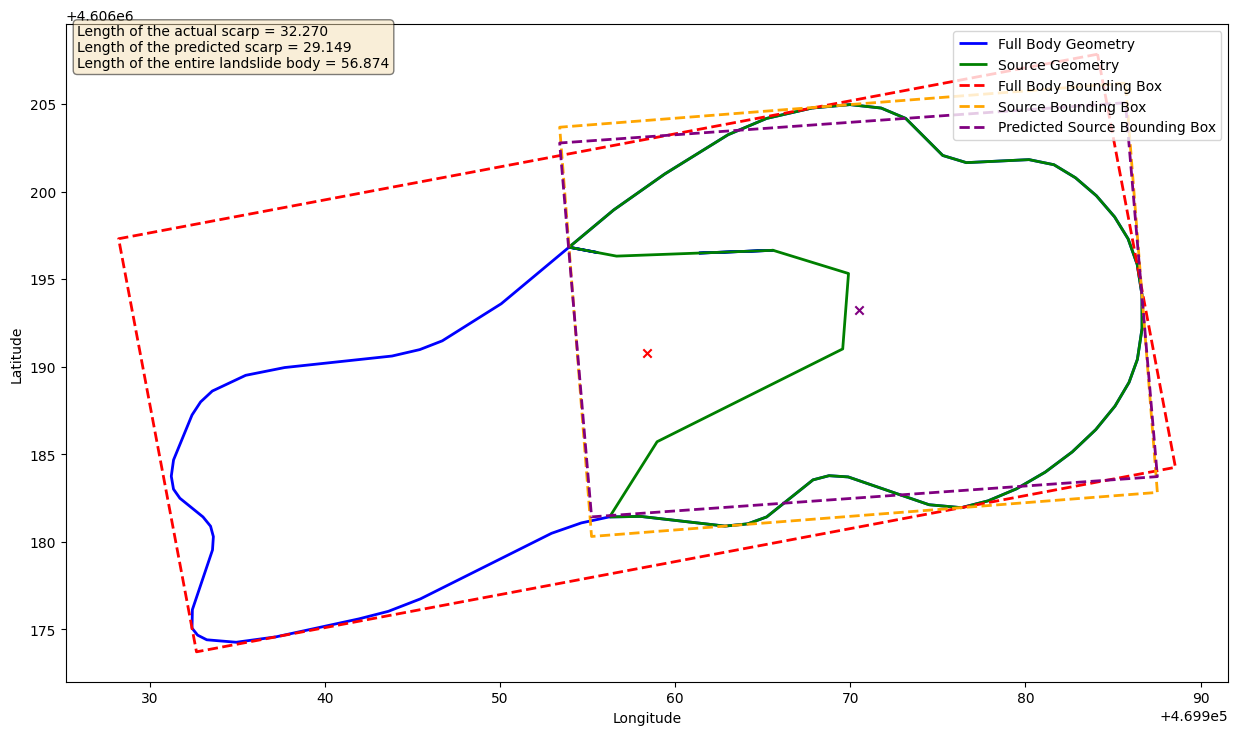

In [21]:
from shapely.affinity import scale
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

i = random.randint(0, len(merged_gdf) - 1)
print('Example number = ', i)
# i= 236 #4,10 

row = merged_gdf.loc[i]
geometry = row['geometry']
geometry_source = row['geometry_source']
bounding_box = geometry.minimum_rotated_rectangle
bounding_box_source = geometry_source.minimum_rotated_rectangle

# Calculate the lengths of the bounding boxes
length_comp = bounding_box.length
length_source = bounding_box_source.length

# Calculate the scaling factor based on the predicted source length
scaling_factor = row['pred_source_length'] / length_source
print('Scaling factor = ', scaling_factor)

# Define a multiplier to increase the scaling factor
scaling_multiplier = 3.5  # Increase the scaling factor by x 
# Recalculate the scaling factor
adjusted_scaling_factor = scaling_factor * scaling_multiplier
print(f'Adjusted scaling factor = {adjusted_scaling_factor}')

print(f"Length of the actual scarp = {row['truth_source_length']}")
print(f"Length of the predicted scarp = {row['pred_source_length']}")
print(f"Length of the entire landslide body = {row['total_length']}")


# Scale the bounding box to match the predicted source length
centroid_x, centroid_y = bounding_box_source.centroid.xy
# scaled_bounding_box_source = scale(bounding_box_source, xfact=1, yfact=scaling_factor, origin=(centroid_x[0], centroid_y[0]))
scaled_bounding_box_source = scale(bounding_box_source, xfact=1, yfact=adjusted_scaling_factor, origin=(centroid_x[0], centroid_y[0]))

# Initialize plot
fig, ax = plt.subplots(figsize=(15,20))

# Plot original and source geometries
gpd.GeoSeries([geometry]).boundary.plot(ax=ax, linewidth=2, color='blue', label='Full Body Geometry')
gpd.GeoSeries([geometry_source]).boundary.plot(ax=ax, linewidth=2, color='green', label='Source Geometry')

# Plot bounding boxes
gpd.GeoSeries([bounding_box]).boundary.plot(ax=ax, linewidth=2, color='red', linestyle='--', label='Full Body Bounding Box')
gpd.GeoSeries([bounding_box_source]).boundary.plot(ax=ax, linewidth=2, color='orange', linestyle='--', label='Source Bounding Box')

# Plot the new scaled bounding box based on the predicted source length
gpd.GeoSeries([scaled_bounding_box_source]).boundary.plot(ax=ax, linewidth=2, color='purple', linestyle='--', label='Predicted Source Bounding Box')


ax.text(0.01, 0.93, f"Length of the actual scarp = {row['truth_source_length']:.3f}\n"
        f"Length of the predicted scarp = {row['pred_source_length']:.3f}\n"
        f"Length of the entire landslide body = {row['total_length']:.3f}", 
        transform=ax.transAxes, verticalalignment='bottom', 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
x, y = bounding_box.centroid.xy
ax.scatter(x, y, marker='x', color='red', zorder=5)

x, y = scaled_bounding_box_source.centroid.xy
ax.scatter(x, y, marker='x', color='purple', zorder=5)

# Labels and legend
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Show plot
plt.show()

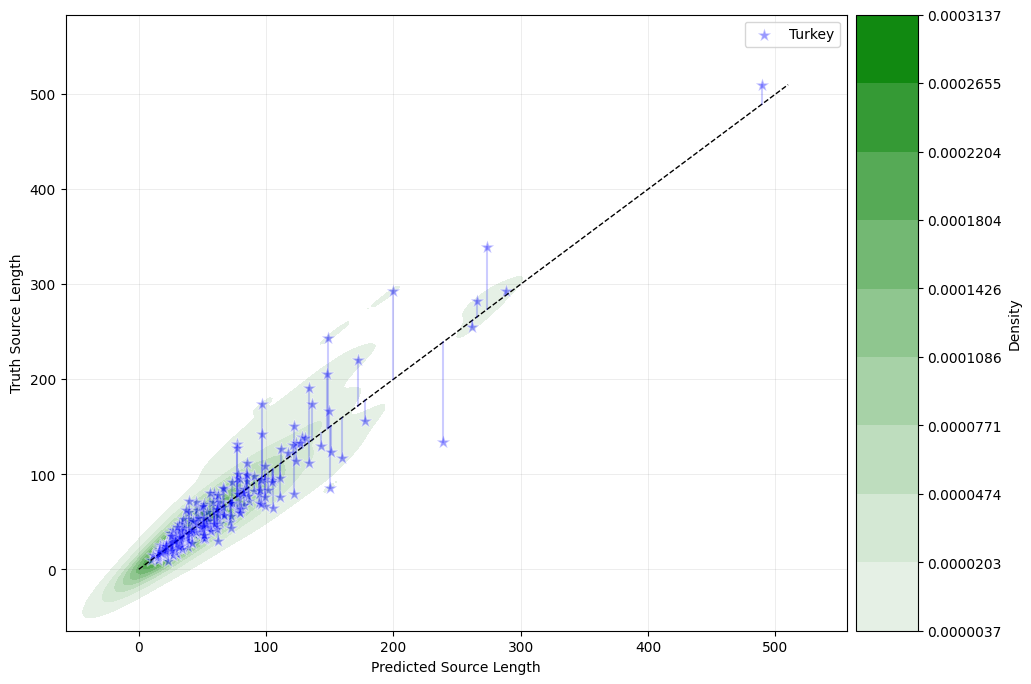

In [20]:
import matplotlib.colors as mcolors
import seaborn as sns

combined_data = pd.concat([
    merged_gdf[['pred_source_length', 'truth_source_length']], 
], ignore_index=True)

plt.figure(figsize=(12, 8))

# Green to yellow color map for KDE
green_yellow_cmap = sns.light_palette("green", as_cmap=True)

# Plot KDE for the combined data using the specified colormap
kde_plot = sns.kdeplot(
    x='pred_source_length', 
    y='truth_source_length', 
    data=combined_data,
    cmap=green_yellow_cmap, 
    fill=True, 
    alpha=1
)

# Find the maximum length for plotting the 45-degree line
max_length = max(merged_gdf[['pred_source_length', 'truth_source_length']].max())

# Plot the 45-degree line
plt.plot([0, max_length], [0, max_length], 'k--', lw=1.0)

# Function to plot residuals for a dataset
def plot_residuals(df, color):
    for _, row in df.iterrows():
        plt.plot([row['pred_source_length'], row['pred_source_length']], 
                 [row['pred_source_length'], row['truth_source_length']], 
                 color=color, alpha=0.2)

# Plot residuals for each country
plot_residuals(merged_gdf, 'blue')


# Scatter plot for each country
sns.scatterplot(x='pred_source_length', y='truth_source_length', data=merged_gdf, marker='*', lw=1, s=100,
                color='blue', label='Turkey', alpha=0.4)

plt.grid(True, which='both', color='gray', linewidth=0.5, linestyle='-', alpha=0.2)

# Add a color bar for the KDE plot
cbar = plt.colorbar(kde_plot.collections[0], ax=plt.gca(), pad=0.01, aspect=10)
cbar.set_label('Density')

plt.xlabel('Predicted Source Length')
plt.ylabel('Truth Source Length')
plt.legend()
# plt.savefig(r'D:\Research Work\Landslide Source-Deposition Separation\Results\plots\prediction_vs_observation_POC.pdf', dpi=1200)
plt.show()

## Prediction Algorithm

In [26]:
def make_3d_boundbox(poly_data,dem_location,inventory_name,kk,l):

    inProj = Proj(init='epsg:4326')
    outProj = Proj(init='epsg:3857')
    data=[]
    eleva_polyon=[]
    DEM_FILE_NAME=dem_location+inventory_name
    DEM = gdal.Open(DEM_FILE_NAME)
    lon_init,lon_res,_,lat_init,_,lat_res = DEM.GetGeoTransform()
    DEM_data=gdal.Dataset.ReadAsArray(DEM)
    #print(np.shape(DEM_data))

    lon_all=np.arange(lon_init,lon_init+np.shape(DEM_data)[1]*lon_res,lon_res)
    lat_all=np.arange(lat_init,lat_init+np.shape(DEM_data)[0]*lat_res,lat_res)
    
    #print (' ***  Upload Complete Shapefiles Of Landslides In Landslide Inventory ***')
    #print('*** Input should be a shapefiles of landslide polygons  *** ' )
    
    inv_lon_min,inv_lon_max,inv_lat_min,inv_lat_max=min_max_inventory(poly_data,lon_res,lat_res)
    
    indices_lon_dem_crop_inventory=np.argwhere((lon_all>inv_lon_min)&(lon_all<inv_lon_max))[:,0]
    indices_lat_dem_crop_inventory=np.argwhere((lat_all>inv_lat_min)&(lat_all<inv_lat_max))[:,0]

    min_indices_lon_dem_crop_inventory=np.min(indices_lon_dem_crop_inventory)
    max_indices_lon_dem_crop_inventory=np.max(indices_lon_dem_crop_inventory)

    min_indices_lat_dem_crop_inventory=np.min(indices_lat_dem_crop_inventory)
    max_indices_lat_dem_crop_inventory=np.max(indices_lat_dem_crop_inventory)
    
    DEM_data=DEM_data[min_indices_lat_dem_crop_inventory:max_indices_lat_dem_crop_inventory,
                          min_indices_lon_dem_crop_inventory:max_indices_lon_dem_crop_inventory]
    
    lon_all=lon_all[min_indices_lon_dem_crop_inventory:max_indices_lon_dem_crop_inventory]
    lat_all=lat_all[min_indices_lat_dem_crop_inventory:max_indices_lat_dem_crop_inventory]          ### check 
          
    poly_xy=np.asarray(poly_data['geometry'][l].exterior.coords)  ## (lon,lat)
    ze_1=poly_xy
    if np.nanmin(ze_1) < 100:
        ze_1=latlon_to_eastnorth(ze_1)
        area_polygon=Polygon(ze_1).area

        #print(area_polygon) 

    min_landslide_lon,max_landslide_lon=np.min(poly_xy[:,0]),np.max(poly_xy[:,0])
    min_landslide_lat,max_landslide_lat=np.min(poly_xy[:,1]),np.max(poly_xy[:,1])

    extra=10
    indices_lon_land=np.argwhere((lon_all>min_landslide_lon-extra*lon_res) & (lon_all<max_landslide_lon+extra*lon_res))[:,0]
    indices_lat_land=np.argwhere((lat_all>min_landslide_lat+extra*lat_res) & (lat_all<max_landslide_lat-extra*lat_res))[:,0]

    DEM_landslide_region_crop=DEM_data[np.min(indices_lat_land):np.max(indices_lat_land)+1,
                                      np.min(indices_lon_land):np.max(indices_lon_land)+1] ############## check 

    lon_landslides_region=lon_all[indices_lon_land]
    lat_landslides_region=lat_all[indices_lat_land]

    ######## for landslide region interpolation ###########################
    lon_mesh,lat_mesh=np.meshgrid(lon_landslides_region,lat_landslides_region)
    lon_mesh,lat_mesh=lon_mesh.flatten(),lat_mesh.flatten()
    DEM_landslide_region_crop_=DEM_landslide_region_crop.flatten()
    lon_mesh_east,lat_mesh_north = transform(inProj,outProj,lon_mesh,lat_mesh)
    
    polygon=poly_data['geometry'][l]
    bound_box=polygon.minimum_rotated_rectangle
    coordinates_bound_box=np.asarray(bound_box.exterior.coords)
    rectangle=np.asarray(coordinates_bound_box)
    #print(rectangle)
    rectangle[:,0],rectangle[:,1] = transform(inProj,outProj,rectangle[:,0],rectangle[:,1])

    lon_mesh_east=np.reshape(lon_mesh_east,(np.shape(lon_mesh_east)[0],1))
    lat_mesh_north=np.reshape(lat_mesh_north,(np.shape(lat_mesh_north)[0],1))
    lonlat_mesh_eastnorth=np.hstack((lon_mesh_east,lat_mesh_north))


    eleva_poly=griddata(lonlat_mesh_eastnorth, DEM_landslide_region_crop_,(rectangle[:,0],rectangle[:,1]),method='cubic')

    a1,b1=rectangle[:,0],rectangle[:,1]
  
    c1=eleva_poly
    a1=a1[:,np.newaxis]
    b1=b1[:,np.newaxis]
    c1=c1[:,np.newaxis]

    eleva_polyon.append(np.hstack((a1,b1,c1)))

    return np.asarray(eleva_polyon[0])

def divide_polygon_intotwo(polygon,ratio,index):
    
    def section(x1, x2, y1, y2,ratio):
        m,n=ratio, 1-ratio
        x = (float)((n * x1)+(m * x2))/(m + n)
        y = (float)((n * y1)+(m * y2))/(m + n)  
        return x,y
    
    bound_box=polygon.minimum_rotated_rectangle
    coordinates_bound_box=np.asarray(bound_box.exterior.coords)
    rectangle=coordinates_bound_box
    
    new_rectangle=[]
    
    index_array=[0,1,2,3,0,1,2,3] 

    x_mid1,y_mid1=section(rectangle[index_array[index+1]][0], rectangle[index_array[index+2]][0], rectangle[index_array[index+1]][1], rectangle[index_array[index+2]][1],ratio)
    x_mid2,y_mid2=section(rectangle[index][0], rectangle[index-1][0], rectangle[index][1], rectangle[index-1][1],ratio)

    new_rectangle=(list(rectangle[index]),list(rectangle[index+1]),
                   [x_mid1,y_mid1],[x_mid2,y_mid2],list(rectangle[index]))
    new_rectangle=np.asarray(new_rectangle) 
           
    new_rectangle_poly=Polygon(new_rectangle)
    polygon1 = new_rectangle_poly.intersection(polygon)    
    polygon2 = polygon.difference(new_rectangle_poly)
    
    if polygon2.geom_type == 'MultiPolygon':
        max_area = -1
        largest_polygon = None
        for poly in polygon2.geoms:  # Iterate through each geometry in the MultiPolygon
            if poly.area > max_area:
                max_area = poly.area
                largest_polygon = poly

        if largest_polygon:
            polygon2 = largest_polygon
        else:
            pass

    return polygon1,polygon2

def process_landslide_data(geodataframe, dem_location, inventory_name, ratio_column_splitting):
    divided_polygons_1 = []
    divided_polygons_2 = []

    for index, row in tqdm(geodataframe.iterrows(), total=geodataframe.shape[0], desc='Predicting the scarp zones !!'):
        try:
            polygon = row['geometry']

            if not polygon.is_valid:
                print(f"Invalid geometry at index {index}. Polygon skipped.")
                continue

            threed_data = make_3d_boundbox(geodataframe, dem_location, inventory_name, 1, index)
            array_sum = [np.sum([threed_data[:, 2][i], threed_data[:, 2][i + 1]]) for i in range(4)]
            index_highest_elevation = np.argmax(array_sum)

            polygon1, polygon2 = divide_polygon_intotwo(polygon, row[ratio_column_splitting], index_highest_elevation)

            gdf_polygon1 = gpd.GeoDataFrame([row], geometry=[polygon1], crs=geodataframe.crs)
            gdf_polygon2 = gpd.GeoDataFrame([row], geometry=[polygon2], crs=geodataframe.crs)

            divided_polygons_1.append(gdf_polygon1)
            divided_polygons_2.append(gdf_polygon2)
        except Exception as e:
            print(f"Error at index {index}: {e}. Polygon skipped.")
            continue

    result_geodataframe_1 = gpd.GeoDataFrame(pd.concat(divided_polygons_1, ignore_index=True))
    result_geodataframe_2 = gpd.GeoDataFrame(pd.concat(divided_polygons_2, ignore_index=True))

    return result_geodataframe_1, result_geodataframe_2

In [23]:
dem_location="D:/Research Work/Landslide Source-Deposition Separation/Data/DEM/Turkey/"
inventory_name="SRTM_Turkey_resampled_10m_lat_lon.tif"

In [24]:
# We convert the data to a WGS format here to use it for splitting between 'scarp' and 'runout' with the DEM
original_crs = CRS.from_epsg(32636)  
datum=merged_gdf
datum = datum.set_geometry('geometry')
datum.crs = original_crs
target_crs = 'EPSG:4326'
data_latlon = datum.to_crs(target_crs)
merge_datafile2=data_latlon

In [27]:
pred_scarp_polygons, pred_runout_polygons = process_landslide_data(geodataframe=merge_datafile2, dem_location=dem_location, inventory_name=inventory_name, ratio_column_splitting='pred_ratio')
actual_scarp_polygons, actual_runout_polygons = process_landslide_data(geodataframe=merge_datafile2, dem_location=dem_location, inventory_name=inventory_name, ratio_column_splitting='truth_ratio')

Predicting the scarp zones !!: 100%|██████████| 235/235 [02:35<00:00,  1.52it/s]


40
Observed scarp length =  173.62962000630796
Prediction scarp length =  97.12868252327462
Deviation metric =  36.0816002473271


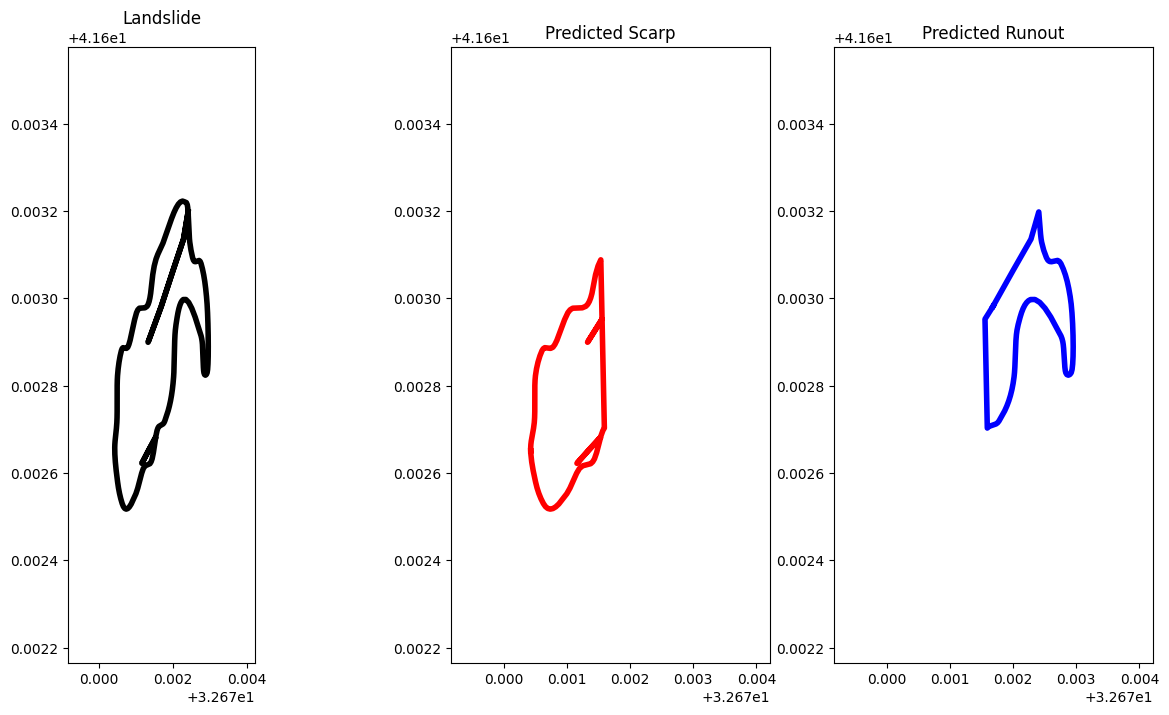

In [34]:
m = random.randint(0, len(pred_scarp_polygons) - 1)
print(m)
print('Observed scarp length = ', merge_datafile2['truth_source_length'][m])
print('Prediction scarp length = ', merge_datafile2['pred_source_length'][m])
print('Deviation metric = ', merge_datafile2['deviation_metric'][m])

plt.figure(figsize=(14, 8), dpi=100)

if 0 <= m < len(merge_datafile2):
    plt.subplot(151)
    coords_full = np.asarray(merge_datafile2.geometry[m].exterior.coords)
    plt.plot(coords_full[:, 0], coords_full[:, 1], lw=4, color='black')
    x_range = coords_full[:, 0].max() - coords_full[:, 0].min()
    y_range = coords_full[:, 1].max() - coords_full[:, 1].min()
    plt.xlim(coords_full[:, 0].min() - 0.5 * x_range, coords_full[:, 0].max() + 0.5 * x_range)
    plt.ylim(coords_full[:, 1].min() - 0.5 * y_range, coords_full[:, 1].max() + 0.5 * y_range)
    plt.title("Landslide")

if 0 <= m < len(pred_scarp_polygons):
    plt.subplot(132)
    coords = np.asarray(pred_scarp_polygons.geometry[m].exterior.coords)
    plt.plot(coords[:, 0], coords[:, 1], lw=4, color='red')
    # x_range = coords[:, 0].max() - coords[:, 0].min()
    # y_range = coords[:, 1].max() - coords[:, 1].min()
    plt.xlim(coords_full[:, 0].min() - 0.5 * x_range, coords_full[:, 0].max() + 0.5 * x_range)
    plt.ylim(coords_full[:, 1].min() - 0.5 * y_range, coords_full[:, 1].max() + 0.5 * y_range)
    plt.title("Predicted Scarp")

if 0 <= m < len(pred_runout_polygons):
    plt.subplot(133)
    coords = np.asarray(pred_runout_polygons.geometry[m].exterior.coords)
    plt.plot(coords[:, 0], coords[:, 1], lw=4, color='blue')
    # x_range = coords[:, 0].max() - coords[:, 0].min()
    # y_range = coords[:, 1].max() - coords[:, 1].min()
    plt.xlim(coords_full[:, 0].min() - 0.5 * x_range, coords_full[:, 0].max() + 0.5 * x_range
    )
    plt.ylim(coords_full[:, 1].min() - 0.5 * y_range, coords_full[:, 1].max() + 0.5 * y_range)
    plt.title("Predicted Runout")

plt.show()

40
Observed scarp length =  173.62962000630796
Prediction scarp length =  97.12868252327462
Deviation metric =  36.0816002473271


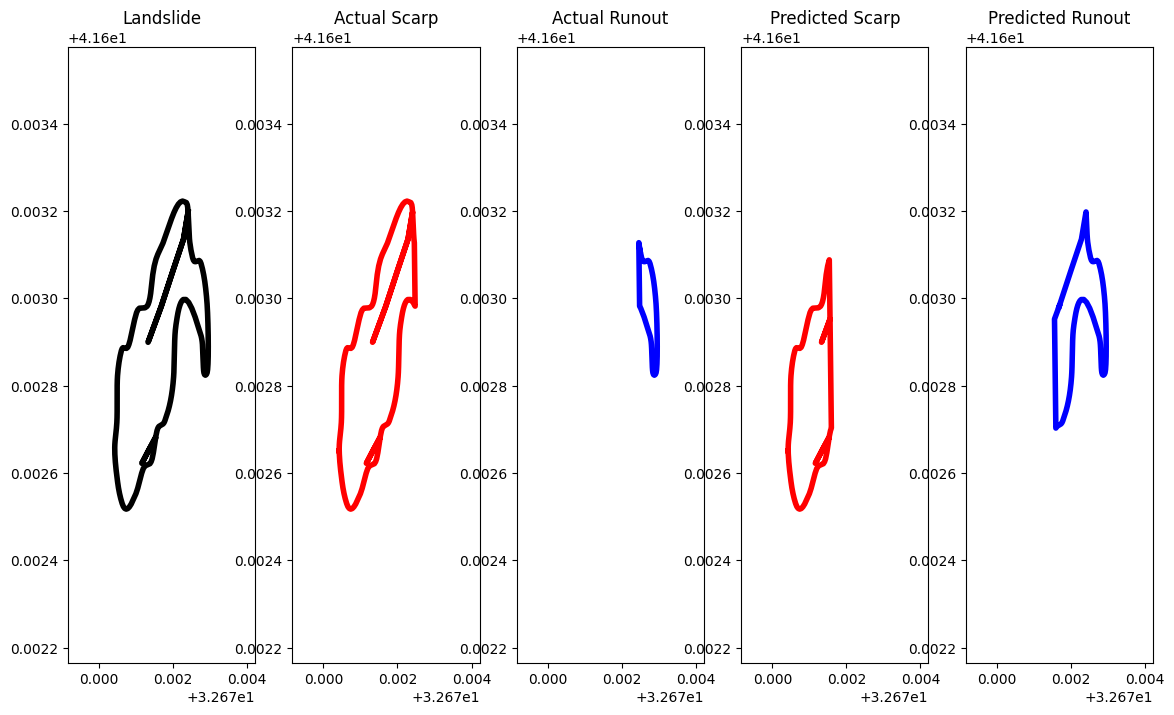

In [35]:
print(m)
print('Observed scarp length = ', merge_datafile2['truth_source_length'][m])
print('Prediction scarp length = ', merge_datafile2['pred_source_length'][m])
print('Deviation metric = ', merge_datafile2['deviation_metric'][m])

plt.figure(figsize=(14, 8), dpi=100)

if 0 <= m < len(merge_datafile2):
    plt.subplot(151)
    coords_full = np.asarray(merge_datafile2.geometry[m].exterior.coords)
    plt.plot(coords_full[:, 0], coords_full[:, 1], lw=4, color='black')
    x_range = coords_full[:, 0].max() - coords_full[:, 0].min()
    y_range = coords_full[:, 1].max() - coords_full[:, 1].min()
    plt.xlim(coords_full[:, 0].min() - 0.5 * x_range, coords_full[:, 0].max() + 0.5 * x_range)
    plt.ylim(coords_full[:, 1].min() - 0.5 * y_range, coords_full[:, 1].max() + 0.5 * y_range)
    plt.title("Landslide")

if 0 <= m < len(actual_scarp_polygons):
    plt.subplot(152)
    coords = np.asarray(actual_scarp_polygons.geometry[m].exterior.coords)
    plt.plot(coords[:, 0], coords[:, 1], lw=4, color='red')
    # x_range = coords[:, 0].max() - coords[:, 0].min()
    # y_range = coords[:, 1].max() - coords[:, 1].min()
    plt.xlim(coords_full[:, 0].min() - 0.5 * x_range, coords_full[:, 0].max() + 0.5 * x_range)
    plt.ylim(coords_full[:, 1].min() - 0.5 * y_range, coords_full[:, 1].max() + 0.5 * y_range)
    plt.title("Actual Scarp")

if 0 <= m < len(actual_runout_polygons):
    plt.subplot(153)
    coords = np.asarray(actual_runout_polygons.geometry[m].exterior.coords)
    plt.plot(coords[:, 0], coords[:, 1], lw=4, color='blue')
    # x_range = coords[:, 0].max() - coords[:, 0].min()
    # y_range = coords[:, 1].max() - coords[:, 1].min()
    plt.xlim(coords_full[:, 0].min() - 0.5 * x_range, coords_full[:, 0].max() + 0.5 * x_range)
    plt.ylim(coords_full[:, 1].min() - 0.5 * y_range, coords_full[:, 1].max() + 0.5 * y_range)
    plt.title("Actual Runout")

if 0 <= m < len(pred_scarp_polygons):
    plt.subplot(154)
    coords = np.asarray(pred_scarp_polygons.geometry[m].exterior.coords)
    plt.plot(coords[:, 0], coords[:, 1], lw=4, color='red')
    # x_range = coords[:, 0].max() - coords[:, 0].min()
    # y_range = coords[:, 1].max() - coords[:, 1].min()
    plt.xlim(coords_full[:, 0].min() - 0.5 * x_range, coords_full[:, 0].max() + 0.5 * x_range)
    plt.ylim(coords_full[:, 1].min() - 0.5 * y_range, coords_full[:, 1].max() + 0.5 * y_range)
    plt.title("Predicted Scarp")

if 0 <= m < len(pred_runout_polygons):
    plt.subplot(155)
    coords = np.asarray(pred_runout_polygons.geometry[m].exterior.coords)
    plt.plot(coords[:, 0], coords[:, 1], lw=4, color='blue')
    # x_range = coords[:, 0].max() - coords[:, 0].min()
    # y_range = coords[:, 1].max() - coords[:, 1].min()
    plt.xlim(coords_full[:, 0].min() - 0.5 * x_range, coords_full[:, 0].max() + 0.5 * x_range)
    plt.ylim(coords_full[:, 1].min() - 0.5 * y_range, coords_full[:, 1].max() + 0.5 * y_range)
    plt.title("Predicted Runout")

plt.show()

In [38]:
merge_pred=merge_datafile2
merge_pred = merge_pred.drop('geometry_source', axis=1)
merge_pred.to_csv(r"path_to_directory\Turkey_pred_lat_lon.csv") # CSV
merge_pred.to_file(r"path_to_directory\Turkey_pred_lat_lon.shp", driver='ESRI Shapefile') # GIS

In [41]:
# To create shapefiles and CSVs of scarp and runout for inspecting in a GIS system

pred_scarp_polygons = pred_scarp_polygons.drop('geometry_source', axis=1)
polygon_only_scarp = pred_scarp_polygons[pred_scarp_polygons.geometry.type.isin(['Polygon', 'MultiPolygon'])] # To remove any geometry that is not a Polygon
polygon_only_scarp.to_file(r"path_to_directory\Turkey_scarp_lat_lon.shp", driver='ESRI Shapefile') # GIS
pred_scarp_polygons.to_csv(r"path_to_directory\Turkey_scarp_lat_lon.csv") # CSV

pred_runout_polygons = pred_runout_polygons.drop('geometry_source', axis=1)
polygon_only_runout = pred_runout_polygons[pred_runout_polygons.geometry.type.isin(['Polygon', 'MultiPolygon'])] # To remove any geometry that is not a Polygon
polygon_only_runout.to_file(r"path_to_directory\Turkey_runout_lat_lon.shp", driver='ESRI Shapefile')
pred_runout_polygons.to_csv(r"path_to_directory\Turkey_runout_lat_lon.csv") # CSV